<a href="https://colab.research.google.com/github/Jack3690/Kugelblitz/blob/main/notebooks/bayestar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Initialization**



In [1]:
!git clone https://github.com/Link4138/BayeSFH-NGC0628 --quiet

In [2]:
!pip install pystan --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.7 MB/s eta 0:00:00


# **Import**

In [3]:
from numpy import append, array, exp, \
                linspace, loadtxt, log10, pi, meshgrid, \
                savetxt, sqrt, where, ones, percentile,trapz
from scipy import special
import matplotlib.pyplot as plt
import time, glob, os, sys
import multiprocessing as mp
import stan
import pandas as pd

## **Likelihood**

In [4]:
def Normal_MGk(fw_dat,fw_err,Iso_sig):    # Error model apparent maginute
    sig2 = fw_err*fw_err + Iso_sig*Iso_sig          # And normal Isochrone

    return  lambda fw_iso : exp( -0.5*(fw_dat-fw_iso)**2 / sig2 ) / sqrt(2.*pi*sig2)

In [5]:
def Phi_MGk(fwj2, sig_fwj2, fwklim, sig_i2):
    b = sig_i2*sig_i2 + sig_fwj2*sig_fwj2
    b1 = sig_i2*sig_i2/b
    b2 = sig_fwj2*sig_fwj2/b
    b3 = sig_i2*sig_i2/sqrt(b)
    return  lambda fw_i2 : special.ndtr( ( fwklim - b1*fwj2 - b2*fw_i2 ) / b3 )

## **Priors**

In [6]:
def IMF_Krp(m, ml=0.1, mint=0.5, mu=350.,a1=1.3,a2=2.3):

    h2 = (mu**(1.-a2)-mint**(1.-a2))/(1.-a2)
    h1 = (mint**(1.-a1)-ml**(1.-a1))/(1.-a1)

    c1 = 1./(h1+h2*mint**(a2-a1))
    c2 = c1*mint**(a2-a1)

    c = ones(len(m))
    c[where(m < mint)] = c1
    c[where(m >= mint)] = c2

    a = ones(len(m))
    a[where(m < mint)] = -a1
    a[where(m >= mint)] = -a2
    imf = c*m**a

    return(imf)

In [7]:
def P_ij_map(IDp, dat, Ndat, Iso, Niso, fw1_lim=20., fw2_lim=20., fw3_lim=20., sig_i=0.1, imf="Krp"):
    filename_p = '%s_Pij_Data_LimMag%.2lf_%srows_%siso_IsoModel_sig%s_IMF_%s_Simple.txt' % (IDp,fw2_lim,str(Ndat),str(Niso),str(sig_i).replace('.','p'), imf)    ## Opening file
    fp = open(os.path.join("pij_cij_results",filename_p),'a')
    args = []

    for j in range(Ndat):                        ## Pij is calcutated row by row, i.e. fix j-th dat and run each i-th isochrone.
#                    0   1     2    3     4         5        6      7       8        9     10
        args.append([j, dat, Niso, Iso, fw1_lim, fw2_lim, fw3_lim, Ndat, filename_p, sig_i, imf])

    with mp.Pool(mp.cpu_count()-1) as p:         ## Pooling Pij rows using all the abailable CPUs (Parallel computation)
        results = p.map(P_ij_row_map, args)
        Pij_out=[]
        for [j,wr] in results:
            fp.write('{}'.format(' '.join(wr))+'\n')
            Pij_out.append(array(wr, dtype=float))
    fp.close()

    return([Pij_out, filename_p])


In [8]:
def P_ij_row_map(args):
    j = args[0]
    dat = args[1]
    Niso = args[2]
    Iso = args[3]

    fw1_lim = args[4]
    fw2_lim = args[5]
    fw3_lim = args[6]

    Ndat = args[7]
    filename_p = args[8]
    sig_i = args[9]
    imf = args[10]

    P_fw1 = Normal_MGk(dat[2][j],dat[3][j],sig_i)
    P_fw2 = Normal_MGk(dat[4][j],dat[5][j],sig_i)
    P_fw3 = Normal_MGk(dat[6][j],dat[7][j],sig_i)

    Phi_fw1 = Phi_MGk(dat[2][j], dat[3][j], fw1_lim, sig_i)
    Phi_fw2 = Phi_MGk(dat[4][j], dat[5][j], fw2_lim, sig_i)
    Phi_fw3 = Phi_MGk(dat[6][j], dat[7][j], fw3_lim, sig_i)

    wr=[]
    for i in range(Niso):                    ## Isochrone loop

        if imf == "Krp":
            imf_p = IMF_Krp(Iso[i][1])
        elif imf == "Slp":
            imf_p = IMF_Salp(Iso[i][1])
        else:
            imf_p = IMF_Krp(Iso[i][1])

        Intg = imf_p*P_fw1(Iso[i][2])*P_fw2(Iso[i][3])*P_fw3(Iso[i][4])*Phi_fw1(Iso[i][2])*Phi_fw2(Iso[i][3])*Phi_fw3(Iso[i][4])

        ## Interand
        p = trapz(Intg,Iso[i][1])

        wr.append(str(p))

    return ([j,wr])

In [9]:
def C_ij_map(IDc, dat, Ndat, Iso, Niso, fw1_lim=20., fw2_lim=20., fw3_lim=20., sig_i=0.1, imf="Krp"):
    filename_c = '%s_Cij_Data_LimMag%.2lf_%srows_%siso_IsoModel_sig%s_IMF_%s_Simple.txt' % (IDc,fw2_lim,str(Ndat),str(Niso),str(sig_i).replace('.','p'), imf)
    fp = open(os.path.join("pij_cij_results",filename_c),'a')   ## output matrix
    args = []
    for j in range(Ndat):                        ## Cij is calcutated row by row, i.e. fix j-th dat and run each i-th isochrone.
        args.append([j, dat, Niso, Iso, fw1_lim, fw2_lim, fw3_lim, Ndat, filename_c, sig_i, imf])

    with mp.Pool(mp.cpu_count()-1) as p:
        results = p.map(C_ij_row_map, args)
        Cij_out=[]
        for [j,wr] in results:
            fp.write('{}'.format(' '.join(wr))+'\n')
            Cij_out.append(array(wr, dtype=float))
    fp.close()

    return(Cij_out)

In [10]:
def C_ij_row_map(args):

    j = args[0]
    dat = args[1]
    Niso = args[2]
    Iso = args[3]

    fw1_lim = args[4]
    fw2_lim = args[5]
    fw3_lim = args[6]

    Ndat = args[7]
    filename_c = args[8]
    sig_i = args[9]
    imf = args[10]

    phi_fw1 = Phi_MGk(dat[2][j], dat[3][j], fw1_lim, sig_i)
    phi_fw2 = Phi_MGk(dat[4][j], dat[5][j], fw2_lim, sig_i)
    phi_fw3 = Phi_MGk(dat[6][j], dat[7][j], fw2_lim, sig_i)

    wr = []
    for i in range(Niso):

        if imf == "Krp":
            imf_c = IMF_Krp(Iso[i][1])
        elif imf=="Slp":
            imf_c = IMF_Salp(Iso[i][1])
        else:
            imf_c = IMF_Krp(Iso[i][1])

        intg_c = imf_c*phi_fw1(Iso[i][2])*phi_fw2(Iso[i][3])*phi_fw3(Iso[i][4])
        p_c = trapz(intg_c,Iso[i][1])

        wr.append(str(p_c))

    return ([j,wr])


## **Stan Code**

In [11]:
code = """

functions{
    real P(int N1, int N2, vector v, matrix M) {
        vector[N1] Mj;
        vector[N1] ln_Mj;

        Mj= M*v;
        for (j in 1:N1){
            if (Mj[j]<=0.)
                Mj[j] = 1.;
        }
        ln_Mj = log(Mj);
        return sum(ln_Mj);
    }
}

data {
    int<lower=0> Nj; // number of data
    int<lower=0> Ni; // number of isochrones
    matrix[Nj,Ni] Pij; // Probability matrix
    matrix[Nj,Ni] Cij; // Normalization matrix
}

parameters {
    simplex[Ni] a;
}

model {
    target += dirichlet_lpdf(a | rep_vector(1., Ni));
    target += P(Nj,Ni,a,Pij);
    target += -1.*P(Nj,Ni,a,Cij);
}

"""

In [12]:
def ai_samp( pij, cij, Ndat, Niso, Nwlk, Nsmp, ID, Name, Z_age):

    ### Data for STAN ###
    dats = {'Nj' : Ndat,
            'Ni' : Niso,
            'Pij': pij,
            'Cij': cij  }

    ############ Running pystan ############

    sm = stan.build(code, data=dats, random_seed=1234)
    fit = sm.sample(num_samples=Nsmp, num_chains=Nwlk, num_warmup=200)
    a_sp = fit["a"].T

    ######### Saving the MCMC sample #########

    N_iso = len(a_sp[0])

    a_perc = array([ percentile(ai,[10,50,90]) for ai in a_sp.T])       ##  10th, 50th, 90th percentiles

    sfh=array([Z_age[:,0], Z_age[:,1], a_perc[:,0], a_perc[:,1], a_perc[:,2] ]).T

    ##
    hd='       Z       Log_age        p10        p50       p90'
    filename = ID+"_ai"+Name+"_Niter"+str(len(a_sp))+".txt"
    savetxt(filename, sfh, header=hd, fmt="%.6f", delimiter="  ")
    return filename, sfh


## **Run Code**

In [13]:
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [16]:
cd /content/BayeSFH-NGC0628/

/content/BayeSFH-NGC0628


In [17]:
N_wlk, N_smp = 20, 500

A_fw1, A_fw2, A_fw3 = 0, 0, 0

fw1_lim, sig_fw1 = 30.0, 0.1             ## Apparent limit magnitus and sigma isochrone model

fw2_lim, sig_fw2 = 30.0, 0.1

fw3_lim, sig_fw3 = 30.0, 0.1

fk_lim = array([fw1_lim,fw2_lim,fw3_lim])
sig_fk = array([sig_fw1,sig_fw2,sig_fw3])

dismod = 29.67                                              ##  Distance modulus

isofiles = ''

########### Reading Isochrones ###########
if (isofiles != ''):
    filelist = []
    f = open(isofiles, "r")
    lines = f.readlines()
    for line in lines:
        filelist.append(line.replace('\n',''))

    print (filelist)
    f.close()
else:
    isodir = 'test_files/Isochrone.test'
    filelist = glob.glob(os.path.join(isodir, "**.*"))

#              F435W  F555W  F814W
#   ph   mass   mag1   mag2   mag3  Z  log_age
iso = array([ loadtxt(k) for k in sorted(filelist) ], dtype=object)
N_iso = len(iso)

Z_age_isos = array([ loadtxt(k)[0][-2:] for k in sorted(filelist) ], dtype=object)

ph_sup = 100
m_inf=0.1

for l in range(N_iso):
    iso[l] = iso[l][where( (iso[l].T[1]>=m_inf) & (iso[l].T[0]<=ph_sup))]       ## mass Truncation & stellar phase Truc
    iso[l] = iso[l].T


################################### DATA #######################################

#  0      1       2        3         4          5         6          7
#  RA    DEC     fw1   fw1_error    fw2     fw2_error    fw3     fw3_error
dt = 'test_files/data.test'
step = int(1)
dat = loadtxt(dt)
msg = "from %d... (FW2 <= %.2lf)" % (len(dat),fw2_lim)
dat = dat[where(dat[:,4]  < fw2_lim)]        # Truncate by apparent magnitude

w_dat = dat[:,0]

# Adding Extinction
dat[:,2] -= A_fw1+dismod
dat[:,4] -= A_fw2+dismod
dat[:,6] -= A_fw3+dismod

print ("Selecting %d %s" % (len(dat), msg))
dat = dat[::step]
dat = dat
dat = dat.T

N_dat = len(dat[0])

parallel = True
IMF = 'Krp'
########################### Execution Routines #################################

start = time.time()
print ("Starting Pij, Cij computation")
if (parallel):
    print ("\tParallel mode...")

    ID = str(int(time.time()))

    Pij_reslt = P_ij_map(ID, dat, N_dat, iso, N_iso, fw1_lim, fw2_lim, fw3_lim, sig_fw1, IMF)
    P_ij, Pij_name = Pij_reslt[0], Pij_reslt[1]

    Name=Pij_name[Pij_name.find("_Pij")+4:Pij_name.find(".txt")]

    C_ij = C_ij_map(ID, dat, N_dat, iso, N_iso, fw1_lim, fw2_lim, fw3_lim, sig_fw1, IMF)

else:
    print ("\tSequential mode...")       ## Not available for the moment
    P_ij(dat, N_dat, r_int, iso, N_iso)
print ("Finished                                ")


end = time.time()

elapsed = end - start

print ("Elapsed time: %02d:%02d:%02d" % (int(elapsed / 3600.), int((elapsed % 3600)/ 60.), elapsed % 60))


###########################################
filename, sfh = ai_samp(P_ij, C_ij, N_dat, N_iso, N_wlk, N_smp, ID, Name, Z_age_isos)
print("Completed")

Selecting 3278 from 3672... (FW2 <= 30.00)
Starting Pij, Cij computation
	Parallel mode...
Finished                                
Elapsed time: 00:00:47
Building...



Building: 47.3s, done.Messages from stanc:
Warning in '/tmp/httpstan_1bmaqkf8/model_7yrpjkol.stan', line 10, column 12: A
    control flow statement inside function P depends on argument v. At
    '/tmp/httpstan_1bmaqkf8/model_7yrpjkol.stan', line 32, column 26 to
    column 27, the value of v depends on parameter(s): a.
Sampling:   0%
Sampling:   5% (700/14000)
Sampling:  10% (1400/14000)
Sampling:  15% (2100/14000)
Sampling:  20% (2800/14000)
Sampling:  25% (3500/14000)
Sampling:  29% (4100/14000)
Sampling:  29% (4101/14000)
Sampling:  29% (4102/14000)
Sampling:  30% (4202/14000)
Sampling:  33% (4601/14000)
Sampling:  35% (4901/14000)
Sampling:  40% (5600/14000)
Sampling:  41% (5700/14000)
Sampling:  41% (5701/14000)
Sampling:  45% (6301/14000)
Sampling:  49% (6800/14000)
Sampling:  49% (6801/14000)
Sampling:  50% (7001/14000)
Sampling:  50% (7002/14000)
Sampling:  51% (7202/14000)
Sampling:  52% (7301/14000)
Sampling:  56% (7800/14000)
Sampling:  60% (8400/14000)
Sampling:  60% (84

Completed


In [18]:
with open(filename, 'r') as f:
    dat = f.readlines()

In [19]:
df = pd.read_csv(filename, sep="  ", skiprows=1, names=['Z','log_Age','p10','p50','p90'],
           engine='python')
df

,Z,log_Age,p10,p50,p90
0,0.0152,7.00000,0.000067,0.000428,0.001406
1,0.0152,7.10000,0.000122,0.000855,0.002807
2,0.0152,7.20000,0.067998,0.078926,0.089081
3,0.0152,7.30000,0.000757,0.004715,0.013093
4,0.0152,7.40001,0.000147,0.000995,0.003277
5,0.0152,7.50001,0.000091,0.000614,0.002062
6,0.0152,7.60001,0.697491,0.710792,0.723932
7,0.0152,7.70001,0.012256,0.017370,0.023121
8,0.0152,7.80001,0.170979,0.182076,0.193095
9,0.0152,7.90001,0.000046,0.000302,0.001012


(0.0, 1.0)

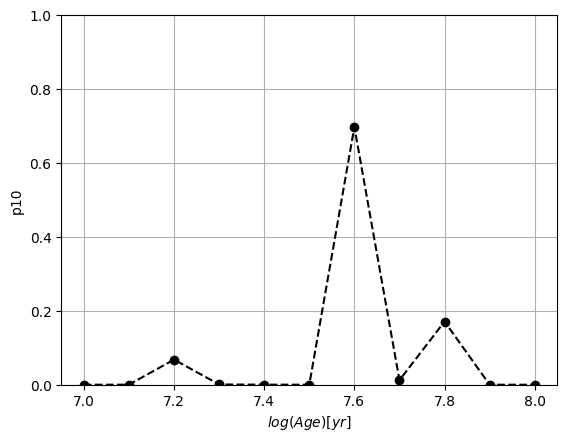

In [20]:
x = df['log_Age']
y = df['p10']

plt.plot(x,y, '--ok')
plt.xlabel(r'$log(Age)[yr]$')
plt.ylabel('p10')
plt.grid()
plt.ylim(0,1)